In [1]:
import time
import pickle
import random
import operator
import numpy as np
import tensorflow as tf

/home/okenfor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading preprocessed data

In [2]:
with open('1.1_read_wikis.pickle', 'rb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    (word2idx_counts, idx2word, sentences) = pickle.load(f)

In [3]:
len(sentences)

211054

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

><img src="images/task.png" width="5%" height="5%">

> **Exercise:** Complete subsampling function. That is, go through `word2idx` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is that probability that a word is discarded. Assign the subsampled data to `train_words`.

In [4]:
def subsampling(word2idx, idx2word, sentences, n_vocab, threshold = 1e-5):
        
    total_count = len(word2idx)
    
    # HERE you complete your code using the probability of sampled word
    train_words = word2idx
    #applying formula above
    freqs = {.....}
    p_drop = {.....}
    train_words = {..... if random.random() < (1 - p_...)}
    
    # restrict vocab size
    sorted_word_idx_count = sorted(train_words.items(), key=operator.itemgetter(1), reverse=True)
    word2idx_small = {}
    new_idx = 0
    idx_new_idx_map = {}
    for idx, count in sorted_word_idx_count[:n_vocab]:
        word = idx2word[idx]
        # print(word, count)
        word2idx_small[word] = new_idx
        idx_new_idx_map[idx] = new_idx
        new_idx += 1
    # let 'unknown' be the last token
    word2idx_small['UNKNOWN'] = new_idx
    idx2word_small = {v:k for k,v in word2idx_small.items()}
    unknown = new_idx

    #example_existence = ('king' in word2idx_small) | ('queen' in word2idx_small) | ('man' in word2idx_small) | (
     #           'woman' in word2idx_small)
    #print(example_existence)
    #if not example_existence:
     #   print("There is no example desired.")
      #  exit(1)

    # map old idx to new idx
    sentences_small = []
    for sentence in sentences:
        if len(sentence) > 1:
            new_sentence = [idx_new_idx_map[idx] if idx in idx_new_idx_map else unknown for idx in sentence]
            sentences_small.append(new_sentence)

    with open('1.2_subsampled_wikis.pickle', 'wb') as f:
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump((sentences_small, word2idx_small, idx2word_small), f, pickle.HIGHEST_PROTOCOL)

    return sentences_small, word2idx_small, idx2word_small

In [5]:
sentences_sampled, word2idx_sampled, idx2word_sampled  = subsampling(word2idx_counts, idx2word, sentences, n_vocab=2000)

In [6]:
[idx2word_sampled[word] for word in sentences_sampled[1]]

['UNKNOWN',
 'UNKNOWN',
 'UNKNOWN',
 'date',
 'UNKNOWN',
 'UNKNOWN',
 'aftermath',
 'UNKNOWN',
 'UNKNOWN',
 'UNKNOWN',
 'UNKNOWN',
 'UNKNOWN']

# Word2Vec: faking on a Neural Network

Citing [Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/): "We’re going to train a simple neural network with a single hidden layer to perform a certain task, but then we’re not actually going to use that neural network for the task we trained it on! Instead, the goal is actually just to learn the weights of the hidden layer–we’ll see that these weights are actually the “word vectors” that we’re trying to learn."

## Making batches: Skip-gram architecture

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

We’ll train the neural network creating a set of batches in order to feed it with word pairs, lets say input, target (word of context C). The example below shows some of the training samples (word pairs) we would take from the sentence “The quick brown fox jumps over the lazy dog.” Using a small window size of 2 just for the example. The word highlighted in blue is the input word.

<img src="images/batch_arch.png" width="50%" height="50%">

><img src="images/task.png" width="5%" height="5%">

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

In [7]:
def get_target(idx2word, words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = ....
    target_words = set(....)
    return list(target_words)

Next, batches of sentences are returned for our network. The idea is that it grabs `batch_size` sentences from sentences list. Then for each of those sentences, iterates per sentence and it gets the target words in the window.

In [8]:
def get_batches(sentences, idx2word, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(sentences)//batch_size
    
    #shuffles sentences
    random.shuffle(sentences)
    
    # only full batches
    sentences = sentences[:n_batches*batch_size]
    
    #for each batch of sentences    
    for idx in range(0, len(sentences), batch_size):
        x, y = [], []
        
        #gets batch of sentences
        batch = sentences[idx:idx+batch_size]
        
        #for each sentence in a batch
        for sentence in batch:
            
            #for each word in a sentence, gets its context
            for idx in range(len(sentence)):
#                 batch_x = idx2word[sentence[idx]]
                batch_x = sentence[idx]
                batch_y = get_target(idx2word, sentence, idx, window_size)
                y.extend(batch_y)
                x.extend([batch_x]*len(batch_y))
                
        # yields a batch
        yield x, y

In [9]:
generator = get_batches(sentences_sampled, idx2word_sampled, 500, 7)

In [10]:
x,y = next(generator)

In [11]:
x[:10]

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 119, 2000]

In [12]:
len(word2idx_sampled)

2001

## Building the graph

The general structure of our network is as follows:

<img src="images/word2vec-skip-gram.png" width="50%" height="50%">

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network (FAKE TASK!). We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

><img src="images/task.png" width="5%" height="5%">

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [13]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, 1], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.

<img src="images/matrix_mult_w_one_hot.png" width="50%" height="50%">

Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this *lookup* for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, to initialize it with a uniform random numbers between -1 and 1 we use [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [14]:
n_vocab = len(word2idx_sampled)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

In the word2vec each word is given a weight equal to it’s frequency (word count) raised to the 3/4 power. The probability for a selecting a word is just it’s weight divided by the sum of weights for all words.

$$ P(w_i) = \frac{  {f(w_i)}^{3/4}  }{\sum_{j=0}^{n}\left(  {f(w_j)}^{3/4} \right) } $$

In [ ]:
# Number of negative labels to sample
n_sampled = 5
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [16]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [17]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


# It's time to run alltogether

In [18]:
%%time
epochs = 100
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(sentences_sampled, idx2word_sampled, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = idx2word_sampled[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = idx2word_sampled[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    
    sim = similarity.eval()
    for i in range(valid_size):
        valid_word = idx2word_sampled[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
            close_word = idx2word_sampled[nearest[k]]
            log = '%s %s,' % (log, close_word)
        print(log)
                    
    save_path = saver.save(sess, "checkpoints/wikipedia.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/100 Iteration: 100 Avg. Training loss: 0.7540 0.6680 sec/batch
Epoch 1/100 Iteration: 200 Avg. Training loss: 0.7750 0.6251 sec/batch
Epoch 2/100 Iteration: 300 Avg. Training loss: 0.8856 0.5505 sec/batch
Epoch 2/100 Iteration: 400 Avg. Training loss: 1.0389 0.5608 sec/batch
Epoch 3/100 Iteration: 500 Avg. Training loss: 1.1748 0.5329 sec/batch
Epoch 3/100 Iteration: 600 Avg. Training loss: 1.1722 0.5628 sec/batch
Epoch 4/100 Iteration: 700 Avg. Training loss: 1.1206 0.5387 sec/batch
Epoch 4/100 Iteration: 800 Avg. Training loss: 1.0637 0.6155 sec/batch
Epoch 5/100 Iteration: 900 Avg. Training loss: 1.0076 0.5504 sec/batch
Epoch 5/100 Iteration: 1000 Avg. Training loss: 0.8786 0.6717 sec/batch
Nearest to notable: withdrawal, armenian, ayrshire, knights, overseas, trapped, 1933, accents,
Nearest to income: 3%, 16, jenny, guthrie, jamaica, walter, bridgeview, deer,
Nearest to met: 45%, 21%, chronicle, nassau, teatro, compensation, positive, tennis,
Nearest to wanted: 48%, destruc

KeyboardInterrupt: 

# Restoring to the last checkpoint

In [ ]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

## Visualizing the word vectors

T-SNE is used to project these vectors into two dimensions while preserving local stucture. 

In [44]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [45]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

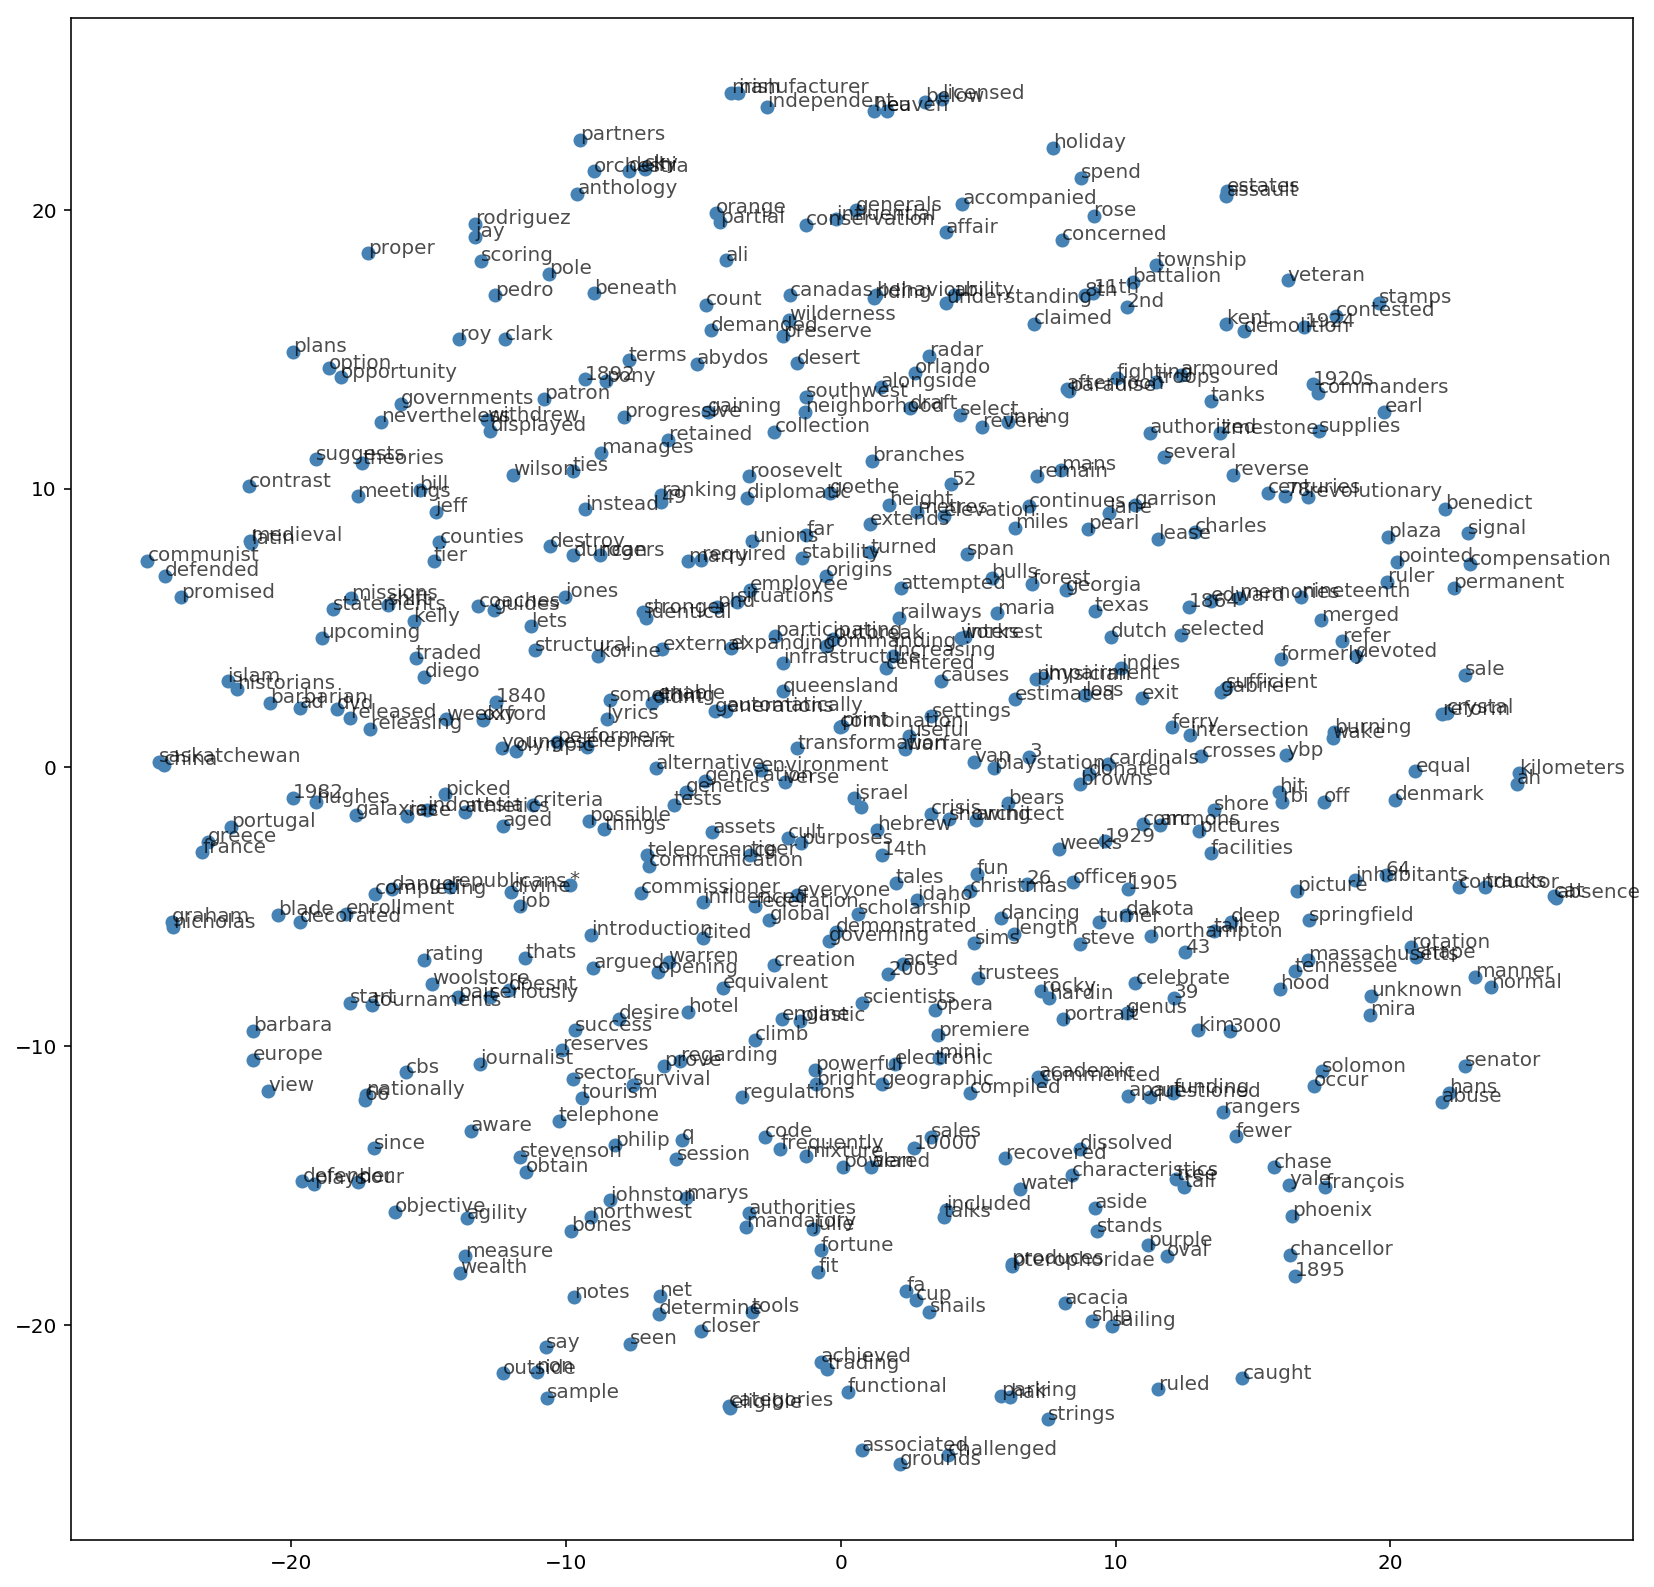

In [47]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(idx2word_sampled[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

# The tensorflow projector

In [ ]:
import os
with open(os.path.join('checkpoints', "metadata.tsv"), 'w') as f:
     for idx in range(len(idx2word_sampled)):
        f.write(idx2word_sampled[idx] + '\n')

In [53]:
from tensorflow.contrib.tensorboard.plugins import projector

summary_writer = tf.summary.FileWriter('checkpoints', sess.graph)
config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
# embedding_conf.tensor_name = 'embedding:0'
embedding_conf.metadata_path = os.path.join('checkpoints', 'metadata.tsv')
projector.visualize_embeddings(summary_writer, config)

In [54]:
embedding_conf.metadata_path

'checkpoints/metadata.tsv'